In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# PSD Logic

In [ ]:
import cv2
import os
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


img = cv2.imread('realface1.jpg',0)
print( img.shape )

# Fourier Transform along the first axis

# Round up the size along this axis to an even number
n = int( math.ceil(img.shape[0] / 2.) * 2 )

# We use rfft since we are processing real values
a = np.fft.rfft(img,n, axis=0)

# Sum power along the second axis
a = a.real*a.real + a.imag*a.imag
a = a.sum(axis=1)/a.shape[1]

# Generate a list of frequencies
f = np.fft.rfftfreq(n)

# Graph it
plt.plot(f[1:],a[1:], label = 'sum of amplitudes over y vs f_x')

# Fourier Transform along the second axis

# Same steps as above
n = int( math.ceil(img.shape[1] / 2.) * 2 )

a = np.fft.rfft(img,n,axis=1)

a = a.real*a.real + a.imag*a.imag
a = a.sum(axis=0)/a.shape[0]

f = np.fft.rfftfreq(n)

plt.plot(f[1:],a[1:],  label ='sum of amplitudes over x vs f_y')

plt.ylabel( 'amplitude' )
plt.xlabel( 'frequency' )
plt.yscale( 'log' )

plt.legend()

plt.savefig( 'realrfft1.jpg' )
#plt.show()


# Model Training

In [4]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import os

# Hyperparameters
IMAGE_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 0.001

# Paths to dataset folders
data_dir = "/kaggle/input/dfd-freq/dfd-freq"  

# Load and preprocess data
data_gen = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.2)

train_gen = data_gen.flow_from_directory(
    data_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

val_gen = data_gen.flow_from_directory(
    data_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

# Load MobileNetV2 base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), alpha=1.0)

# Freeze the base model layers
base_model.trainable = False

# Add custom layers
global_avg_pooling = GlobalAveragePooling2D()(base_model.output)
output_layer = Dense(1, activation='sigmoid')(global_avg_pooling)
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()
# Train the model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    steps_per_epoch= train_gen.samples // BATCH_SIZE,  # 57
    validation_steps=val_gen.samples // BATCH_SIZE    # 15
)

# Print accuracy for each epoch
for epoch, acc in enumerate(history.history['accuracy'], start=1):
    print(f"Epoch {epoch}: Accuracy = {acc:.4f}")

# Save the trained model
model.save("/kaggle/working/mobilenetv2_binary_classification.h5")

Found 1808 images belonging to 2 classes.
Found 451 images belonging to 2 classes.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 179ms/step - accuracy: 0.7573 - loss: 0.4993 - val_accuracy: 0.8929 - val_loss: 0.3768
Epoch 2/10
 1/56 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7500 - loss: 0.7414

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7500 - loss: 0.7414 - val_accuracy: 0.8929 - val_loss: 0.3748
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.9050 - loss: 0.3113 - val_accuracy: 0.8929 - val_loss: 0.3624
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9375 - loss: 0.2250 - val_accuracy: 0.8929 - val_loss: 0.3622
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.8786 - loss: 0.3471 - val_accuracy: 0.8929 - val_loss: 0.3756
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8750 - loss: 0.4169 - val_accuracy: 0.8929 - val_loss: 0.3720
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.8965 - loss: 0.3072 - val_accuracy: 0.8951 - val_loss: 0.3676
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8750 - loss: 0.3327 - val_accuracy: 0.8929 - val_loss: 0.3689
Epoch 9/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.8934 - loss: 0.3224 - val_accuracy: 0.8929 - val_loss: 0.

# Evaluation

Found 2259 files belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━

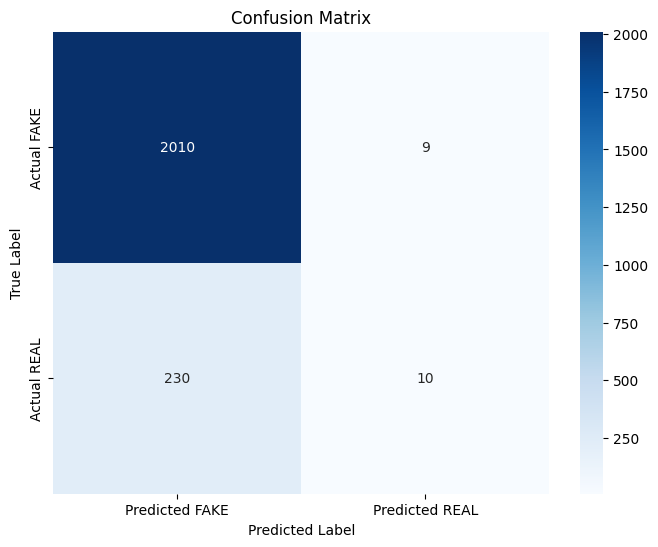

In [5]:
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Load trained model
model = tf.keras.models.load_model("mobilenetv2_binary_classification.h5")

# Configuration
TEST_DIR = "/kaggle/input/dfd-freq/dfd-freq"  # Path to test dataset
IMAGE_SIZE = 224
BATCH_SIZE = 32

# Create test dataset
test_dataset = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False,  # Critical for correct label ordering
    label_mode='binary'
)

# Normalize images (same as training preprocessing)
def preprocess(image, label):
    return image / 255.0, label

test_dataset = test_dataset.map(preprocess)

# Get true labels and predictions
y_true = []
y_pred = []

for images, labels in test_dataset:
    y_true.extend(labels.numpy())
    predictions = model.predict(images)
    y_pred.extend((predictions > 0.5).astype(int).flatten())  # Threshold at 0.5

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['FAKE', 'REAL']))

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted FAKE', 'Predicted REAL'],
            yticklabels=['Actual FAKE', 'Actual REAL'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.savefig('/kaggle/working/confusion_matrix.png')  # Save visualization
plt.show()

# Inference

In [ ]:
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load the trained model
model = tf.keras.models.load_model("mobilenetv2_binary_classification.h5")

# Path to the image for inference
image_path = "/kaggle/input/inference/inference_real.png"

# Preprocess the image
IMAGE_SIZE = 224
img = load_img(image_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
img_array = img_to_array(img)  # Convert the image to a NumPy array
img_array = img_array / 255.0  # Normalize to [0, 1]
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Perform inference
prediction = model.predict(img_array)
confidence = prediction[0][0]
# Interpret the result
if prediction[0][0] > 0.5:
    print(f"The image is classified as: Fake, confodence : {confidence:.2f}")
else:
    print(f"The image is classified as: Real, confidence : {1- confidence:.2f}")